In [20]:
import numpy as np
from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

In [21]:
# set parameters
LEARNING_RATE = 0.001#学习率
BATCH_SIZE = 32
EPOCHS = 20
RANDOM_SEED = 20

IMG_SIZE = 32
CLASSES_NUM = 10

In [22]:
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

In [23]:
train_dataset = datasets.MNIST(root='mnist_data',
                               train=True,#training.pt创建数据集
                               transform=transforms,
                               download=True)

valid_dataset = datasets.MNIST(root='mnist_data',
                               train=False,#从test.pt创建数据集。
                               transform=transforms)

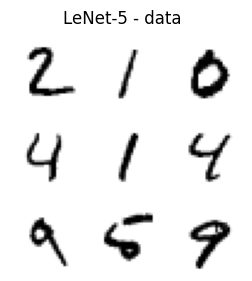

In [44]:
fig,ax = plt.subplots(figsize = (3,3))

for index in range(1, 10):
    plt.subplot(3, 3, index)
    plt.axis('off')
#     plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
#     with torch.no_grad():
#         model.eval()
#         _, probs = model(valid_dataset[index][0].unsqueeze(0))
#     title = '{}-{:.0f}%'.format(torch.argmax(probs),torch.max(probs * 100))
#     title = f'{torch.argm,x(probs)} ({torch.max(probs * 100):.0f}%)'
#     plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - data');

In [24]:
# Define the data loaders
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False)

In [25]:
class LenNet5(nn.Module):
    def __init__(self, n_classes):
        super(LenNet5, self).__init__()

        # inchannels, out_channels, kernel_size, stride=1
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(1, 6, 5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(6, 16, 5),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(16, 120, 5),
            nn.Tanh()
        )

        # two affine operations: y = Wx + b
        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):#模型进行预测的时候自动调用forward
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs
#     返回两个值

In [26]:
# valid 表示测试集

In [27]:
#实例化损失函数和最优化算法
torch.manual_seed(RANDOM_SEED)

model = LenNet5(CLASSES_NUM)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [28]:
def plot_losses(train_losses,valid_losses):
    plt.style.use('seaborn')
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig,ax = plt.subplots(figsize = (8,5))
    ax.plot(train_losses,color = 'blue',label = 'Training loss')#用默认x轴
    ax.plot(valid_losses,color = 'red',label = 'Validation loss')
    ax.set(title = 'Loss per epochs',xlabel = 'Epoch',ylabel = 'Loss')
    ax.legend()
    fig.show()
    
    plt.style.use('default')
    return None

In [36]:
def get_accuracy(model,data_loader):
    correct_pred = 0
    n = 0
    with torch.no_grad():#反向传播不求偏导数
        model.eval()
        for X,y_true in data_loader:
            _,y_pred = model(X)
            _,predicted_labels = torch.max(y_pred,1)#data dim
            
            n+=y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
    return correct_pred.float()/n

In [11]:
def train(train_loader, model, criterion, optimizer):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    runnin_loss = 0

    for X, y_true in train_loader:
        optimizer.zero_grad()

        # Forward: getting the predictions for the batch using current weight
        y_hat, _ = model(X)
        # Calculate the value of the loss function
        loss = criterion(y_hat, y_true)
        runnin_loss += loss.item() * X.size(0)

        # Backward: The weights are adjusted based on the loss
        loss.backward()
        optimizer.step()
        
    epoch_loss = runnin_loss / len(train_loader.dataset)
    #每一轮训练的平均loss
    return model, optimizer, epoch_loss

In [30]:
def validate(valid_loader, model, criterion):
    '''
    Function for the validation step of the training loop
    '''

    model.eval()
    running_loss = 0

    for X, y_true in valid_loader:
        # Forward pass and record loss
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss


In [33]:
def training_loop(model,criterion,optimizer,train_loader,valid_loader,epochs,print_every = 1):
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    for epoch in range(0,epochs):
        model,optimizer,train_loss = train(train_loader,model,criterion,optimizer)
        train_losses.append(train_loss)
        
        with torch.no_grad():
            model,valid_loss = validate(valid_loader,model,criterion)
            valid_losses.append(valid_loss)
        if (epoch % print_every) == (print_every - 1):#到达间隔
            train_acc = get_accuracy(model,train_loader)
            valid_acc = get_accuracy(model,valid_loader)
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')
    plot_losses(train_losses,valid_losses)
    return model,optimizer,(train_losses,valid_losses)

16:44:06 --- Epoch: 0	Train loss: 0.0569	Valid loss: 0.0607	Train accuracy: 98.64	Valid accuracy: 98.09
16:44:49 --- Epoch: 1	Train loss: 0.0440	Valid loss: 0.0513	Train accuracy: 99.05	Valid accuracy: 98.40
16:45:34 --- Epoch: 2	Train loss: 0.0370	Valid loss: 0.0518	Train accuracy: 99.15	Valid accuracy: 98.54
16:46:18 --- Epoch: 3	Train loss: 0.0299	Valid loss: 0.0487	Train accuracy: 99.28	Valid accuracy: 98.60
16:47:01 --- Epoch: 4	Train loss: 0.0257	Valid loss: 0.0498	Train accuracy: 99.32	Valid accuracy: 98.55
16:47:43 --- Epoch: 5	Train loss: 0.0227	Valid loss: 0.0459	Train accuracy: 99.44	Valid accuracy: 98.58
16:48:25 --- Epoch: 6	Train loss: 0.0198	Valid loss: 0.0436	Train accuracy: 99.44	Valid accuracy: 98.82
16:49:07 --- Epoch: 7	Train loss: 0.0188	Valid loss: 0.0498	Train accuracy: 99.44	Valid accuracy: 98.60
16:49:50 --- Epoch: 8	Train loss: 0.0155	Valid loss: 0.0511	Train accuracy: 99.60	Valid accuracy: 98.60
16:50:31 --- Epoch: 9	Train loss: 0.0149	Valid loss: 0.0440	Trai

D:\Download\Anaconda\neirong\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


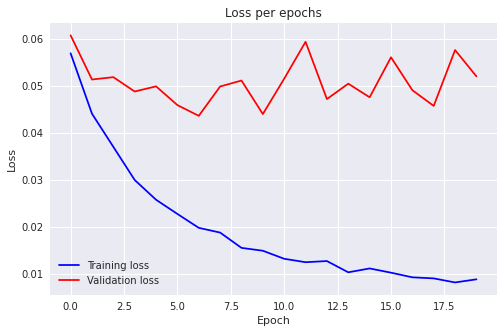

In [37]:
#开始训练
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, EPOCHS)

tensor([[4.0091e-07, 3.3773e-07, 1.0000e+00, 9.0247e-11, 1.4228e-11, 3.7614e-12,
         7.3356e-09, 3.6028e-11, 4.7649e-08, 6.4049e-12]])
tensor([[9.4912e-11, 1.0000e+00, 4.3912e-11, 1.3320e-13, 5.2550e-09, 1.7981e-13,
         7.1159e-09, 2.7819e-08, 6.8078e-10, 1.0276e-12]])
tensor([[1.0000e+00, 2.6480e-12, 7.0131e-09, 4.2511e-09, 4.3601e-12, 9.5382e-10,
         1.0027e-06, 4.2275e-09, 8.3491e-09, 1.2533e-08]])
tensor([[1.1160e-09, 1.3334e-09, 2.0782e-09, 7.9135e-12, 1.0000e+00, 8.3169e-12,
         6.9049e-08, 2.8215e-08, 6.8768e-10, 3.9421e-07]])
tensor([[1.9318e-09, 1.0000e+00, 2.6622e-11, 9.3992e-13, 3.0329e-08, 1.8329e-13,
         5.9918e-09, 6.9006e-08, 3.2446e-08, 1.0372e-11]])
tensor([[1.9034e-11, 1.2522e-05, 1.9540e-11, 3.3011e-10, 9.9990e-01, 1.8372e-08,
         2.7134e-08, 4.3555e-06, 8.0352e-05, 1.8884e-06]])
tensor([[1.2936e-08, 1.8156e-10, 1.1177e-06, 9.4370e-04, 8.7190e-07, 8.1408e-05,
         1.3962e-11, 6.3860e-08, 2.2223e-08, 9.9897e-01]])
tensor([[9.9791e-08,

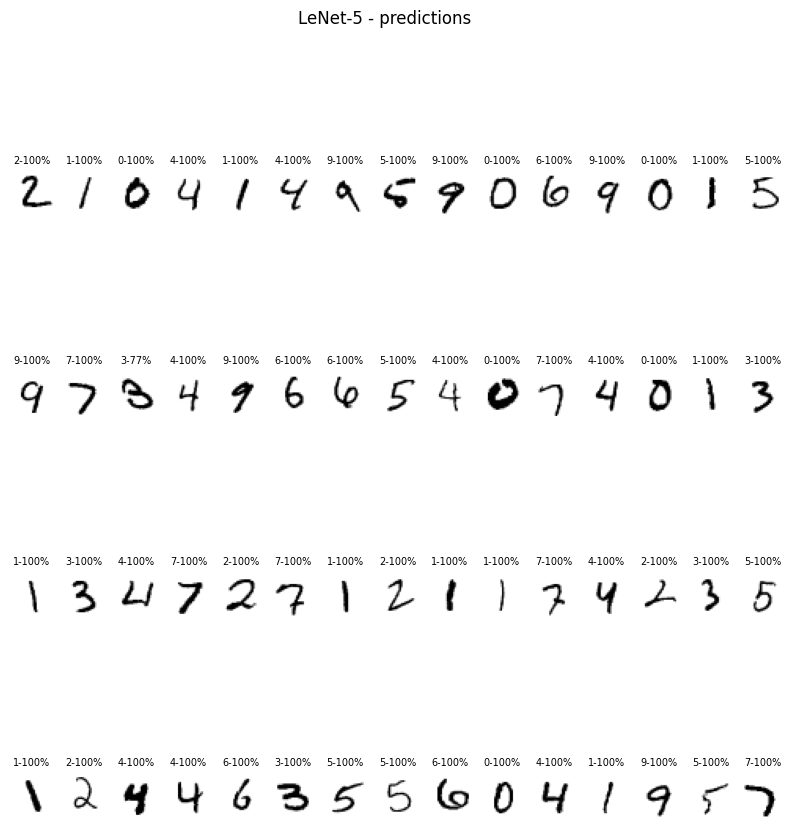

In [50]:
ROW_IMG = 15
N_ROWS = 4

# fig = plt.figure()
fig,ax = plt.subplots(figsize = (10,10))
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
#         probs = model(valid_dataset[index][0].unsqueeze(0))
#         print(probs)
        _, probs = model(valid_dataset[index][0].unsqueeze(0))
#         print(probs)
    title = '{}-{:.0f}%'.format(torch.argmax(probs),torch.max(probs * 100))
#     title = f'{torch.argm,x(probs)} ({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions');

In [46]:
t

NameError: name 't' is not defined